In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data.csv')

In [6]:
print("there are {} unique item".format(data.itemDescription.unique().size)) 

there are 167 unique item


In [8]:
transactions = [a[1]['itemDescription'].tolist() for a in list(data.groupby(['Member_number','Date']))]

In [10]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [12]:
df.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
from mlxtend.frequent_patterns import apriori, association_rules
freq_items = apriori(df, min_support=0.001, use_colnames=True, verbose=1)
freq_items.head(7)

Processing 28 combinations | Sampling itemset size 4e 3


,support,itemsets
0,0.004010,(Instant food products)
1,0.021386,(UHT-milk)
2,0.001470,(abrasive cleaner)
3,0.001938,(artif. sweetener)
4,0.008087,(baking powder)
5,0.001136,(bathroom cleaner)
6,0.033950,(beef)


In [15]:
rules = association_rules(freq_items, metric="confidence", min_threshold=0.001)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(bottled water),(UHT-milk),0.060683,0.021386,0.001069,0.017621,0.823954,-0.000228,0.996168,-0.185312
1,(UHT-milk),(bottled water),0.021386,0.060683,0.001069,0.050000,0.823954,-0.000228,0.988755,-0.179204
2,(UHT-milk),(other vegetables),0.021386,0.122101,0.002139,0.100000,0.818993,-0.000473,0.975443,-0.184234
3,(other vegetables),(UHT-milk),0.122101,0.021386,0.002139,0.017515,0.818993,-0.000473,0.996060,-0.201119
4,(rolls/buns),(UHT-milk),0.110005,0.021386,0.001804,0.016403,0.767013,-0.000548,0.994934,-0.254457


In [177]:
import matplotlib.pyplot as plt
basket = pd.read_csv('bread basket.csv')
import io
import itertools
from itertools import chain, combinations

In [180]:
basket['Item'] = basket['Item'].str.lower()
basket['Item'] = basket['Item'].str.strip()

In [181]:
basket['Datetime'] = pd.to_datetime(basket['date_time'])

In [182]:
basket['date'] = basket['Datetime'].dt.date
basket['month'] = basket['Datetime'].dt.month
basket['day'] = basket['Datetime'].dt.weekday
basket['hour'] = basket['Datetime'].dt.hour

basket['day'] = basket['day'].replace((0,1,2,3,4,5,6), 
('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))

In [183]:
basket.drop(columns='date_time',inplace=True)

In [185]:
#split dataset
# count the number of unique transactions
n_transactions = len(set(basket['Transaction']))
print(n_transactions)

# split the transactions into 6 datasets of different sizes
datasets = []
for i in range(1, 6): 
    # calculate the number of transactions to include in the dataset
    #n_transactions_subset = int(n_transactions * i / 5)
    n_transactions_subset = int(500 * i / 5+1)
    print(n_transactions_subset)
    
    # select the transactions to include in the dataset
    selected_transactions = list(range(n_transactions_subset))
    
    # filter the dataset to include only the selected transactions
    dataset = basket[basket['Transaction'].isin(selected_transactions)]
    
    # append the dataset to the list of datasets
    datasets.append(dataset)


620
101
201
301
401
501


In [186]:
def hot_encode(x): 
    if(x==0): 
        return False
    if(x>0): 
        return True

## Apriori Algorithm

In [187]:
def Apriori(basket):
  print('Apriori:')
  transactions = basket.groupby(['Transaction', 'Item'])['Item'].count().reset_index(name='Number of Items')
  table = transactions.pivot_table(index='Transaction', columns='Item', values='Number of Items', aggfunc='sum').fillna(0)
  final_table = table.applymap(hot_encode) 
    
  start_time = time.time()
  frequence = apriori(final_table, min_support=0.015, use_colnames=True)
  #print('frequent:')
  #print(frequence)
  frequent_itemsets_time = time.time() - start_time
  start_time = time.time()
  rules = association_rules(frequence, metric="confidence", min_threshold=0.5)
  high_confidence_rules_time = time.time() - start_time
  #rules =rules.sort_values('confidence', ascending = False, inplace=True)
  #print('rules:')
  #print(rules)
  
  print("Time for frequent itemset generation:", frequent_itemsets_time)
  print("Time for high-confidence rules generation:", high_confidence_rules_time)


  return frequent_itemsets_time, high_confidence_rules_time, 

## brute_force


In [188]:
'''
def brute_force(data):
    print('Brute_force:')
    # Minimum support
    min_support = 0.015

    # Confidence threshold
    min_confidence = 0.5
 
    # Start time for frequent itemset generation
    start_time = time.time()

    # Generate frequent itemsets using brute-force approach

    # Group items by transaction
    transactions = data.groupby(['Transaction'])['Item'].apply(set)
    print(transactions)
    max_length = transactions.apply(len).max()
    print(max_length)
    # Get unique items from dataset
    unique_items = set(chain(*transactions))
    print('# unique_items:')
    print(len(unique_items))

    # Get all possible subsets of unique items
    item_combinations = chain.from_iterable(combinations(unique_items, i) for i in range(len(unique_items) + 1))
    
    # Dictionary to hold support counts for each itemset
    support_counts = {}
    
    # Count support for each itemset in dataset
    for itemset in item_combinations:
        itemset_count = sum(1 for transaction in transactions if set(itemset).issubset(transaction))
        support = itemset_count / len(transactions)
        if support >= min_support:
            support_counts[itemset] = support
    # End time for frequent itemset generation
    end_time = time.time()
    frequent_itemsets_time = end_time - start_time
    # Print time taken for frequent itemset generation
    #print('frequent')
    print('support_counts:')
    print(len(support_counts))
    
    # Start time for rule generation
    start_time = time.time()
    
    # Generate rules using brute-force approach
    rules = []
    for itemset, support in support_counts.items():
        for i in range(1, len(itemset)):
            for antecedent in combinations(itemset, i):
                antecedent = set(antecedent)
                consequent = set(itemset) - antecedent
                
                support_antecedent = sum(1 for t in transactions if set(antecedent).issubset(t)) / len(transactions)
                support_itemset = sum(1 for t in transactions if set(itemset).issubset(t)) / len(transactions)
                confidence = support_itemset / support_antecedent
                
                if support_itemset >= min_support and confidence >= min_confidence:
                    rules.append((antecedent, consequent, support_itemset, confidence))
    # End time for rule generation
    end_time = time.time()
    high_confidence_rules_time=end_time - start_time
    # Print time taken for rule generation
    #print('rules:')
    #print(rules)
    print("Time taken for frequent itemset generation:",frequent_itemsets_time)
    print("Time taken for rule generation:", high_confidence_rules_time)
    return frequent_itemsets_time, high_confidence_rules_time
'''
'''
def brute_force(data):
    print('Brute_force:')
    # Minimum support
    min_support = 0.015

    # Confidence threshold
    min_confidence = 0.5
 

    # Generate frequent itemsets using brute-force approach

    # Group items by transaction
    transactions = data.groupby(['Transaction'])['Item'].apply(set)
#     max_length = transactions.apply(len).max()
#     print('w:')
#     print(max_length)
#     # Get unique items from dataset
#     unique_items = set(chain(*transactions))
#     print('# unique_items (d):')
#     print(len(unique_items))
    
    item_counts = {}
    rule_counts = {}
    
    # Start time for frequent itemset generation
    start_time = time.time()

    # Count item occurrences
    for transaction in transactions:
        for item in transaction:
            item_counts[item] = item_counts.get(item, 0) + 1

    # Generate all itemsets and rules
    for i in range(1, len(item_counts)+1):
        for itemset in combinations(item_counts.keys(), i):
            itemset = set(itemset)
            for j in range(1, len(itemset)):
                for antecedent in combinations(itemset, j):
                    antecedent = set(antecedent)
                    consequent = itemset - antecedent
                    if len(consequent) == 0:
                        continue

                    # Check support and confidence
                    support = sum(1 for t in transactions if antecedent.issubset(t)) / len(transactions)
                    if support >= min_support:
                        confidence = sum(1 for t in transactions if antecedent.issubset(t) and consequent.issubset(t)) / sum(1 for t in transactions if antecedent.issubset(t))
                        if confidence >= min_confidence:
                            rule_counts[(tuple(antecedent), tuple(consequent))] = (support, confidence)


    end_time = time.time()
    high_confidence_rules_time_from_scratch=end_time - start_time
    print("Time taken for rule generation from scratch:", high_confidence_rules_time_from_scratch)
    
    print(rule_counts)
    
    return int(1),high_confidence_rules_time_from_scratch
'''
def brute_force_large_dataset(data,n):
    print('Brute_force:')
    # Minimum support
    min_support = 0.015

    # Confidence threshold
    min_confidence = 0.5
 
    # Group items by transaction
    transactions = data.groupby(['Transaction'])['Item'].apply(set)
    max_length = transactions.apply(len).max()
    w=max_length
    # Get unique items from dataset
    unique_items = set(chain(*transactions))
    d=len(unique_items)
    
    bf_times_frequent_estimated=5.6*pow(10,-8)*n*pow(2,d)*w
    bf_times_rules_estimated=2.6*pow(10,-8)*(pow(3,d)-pow(2,(d+1))+1)*n*w
    
    
    return d, w,bf_times_frequent_estimated,bf_times_rules_estimated
    

In [ ]:
# print the number of transactions in each dataset
apriori_times_frequent = []
apriori_times_rules = []
bf_times_frequent = []
bf_times_rules = []
dataset_len = []
for i, dataset in enumerate(datasets):
    print(f"Dataset {i+1}: {len(set(dataset['Transaction']))} transactions")
    length=len(set(dataset['Transaction']))
    #apriori_frequent_itemsets_time, apriori_high_confidence_rules_time= Apriori(dataset)
    bf_frequent_itemsets_time, bf_high_confidence_rules_time= brute_force(dataset)
    print('----------------------------------------------------------------------')
    apriori_times_frequent.append(apriori_frequent_itemsets_time)
    apriori_times_rules.append(apriori_high_confidence_rules_time)
    bf_times_frequent.append(bf_frequent_itemsets_time)
    bf_times_rules.append(bf_high_confidence_rules_time)
    dataset_len.append(length)

In [ ]:
def to_plot(times_1, times_2,times_3, dataset_len, title ):
  # plot the measured time and the estimated time
  plt.scatter(dataset_len, times_1, s=10,label="Apriori")
  plt.scatter(dataset_len, times_2, s=10,color='r', label="Brute-force")
  plt.scatter(dataset_len, times_3, color='black', marker='+', label="Brute-force (Estimated)")
  plt.title(title)
  plt.xlabel("Dataset Size")
  plt.ylabel("Time (seconds)")
  plt.legend()
  plt.show()

In [192]:
#estimate time on small datasets
d_list=[10,14,15,16,18]
n_list=[10,20,30,40,50]
w_list=[4,5,5,5,5]
bf_times_frequent_estimated=[]
bf_times_rules_estimated=[]
for time, d,n,w in zip(bf_times_rules, d_list,n_list,w_list):
    time_1=5.6*pow(10,-8)*n*pow(2,d)*w
    bf_times_frequent_estimated.append(time_1)
    time_2=2.6*pow(10,-8)*(pow(3,d)-pow(2,(d+1))+1)*n*w
    bf_times_rules_estimated.append(time_2)



[0.05928208, 12.3505252, 55.705150800000006, 223.16138, 2514.8253130000003]


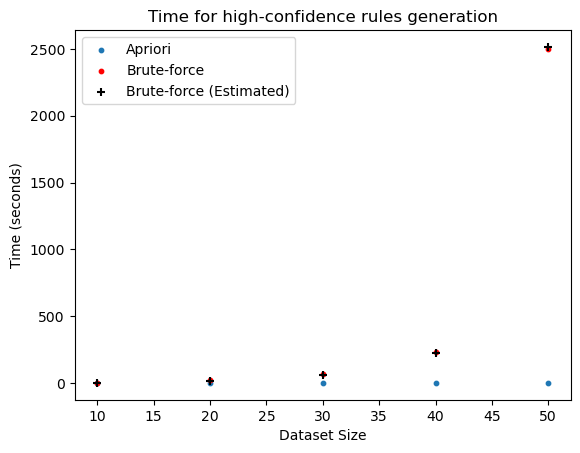

In [193]:
#plot time on small datasets
dataset_len = [10,20,30,40,50]

to_plot(apriori_times_frequent, bf_times_frequent,bf_times_frequent_estimated, dataset_len, 'Time for frequent itemset generation')
to_plot(apriori_times_rules_from_sratch, bf_times_rules_from_scrach,bf_times_rules_estimated, dataset_len, 'Time for high-confidence rules generation')


In [189]:
#estimate time on large datasets
apriori_times_frequent = []
apriori_times_rules = []
bf_times_frequent_estimated = []
bf_times_rules_estimated = []
dataset_len = []
for i, dataset in enumerate(datasets):
    print(f"Dataset {i+1}: {len(set(dataset['Transaction']))} transactions")
    length=len(set(dataset['Transaction']))
    apriori_frequent_itemsets_time, apriori_high_confidence_rules_time= Apriori(dataset)
    bf_frequent_itemsets_time, bf_high_confidence_rules_time, time1, time2= brute_force_large_dataset(dataset,length)
    print('----------------------------------------------------------------------')
    apriori_times_frequent.append(apriori_frequent_itemsets_time)
    apriori_times_rules.append(apriori_high_confidence_rules_time)
    bf_times_frequent_estimated.append(time1)
    bf_times_rules_estimated.append(time2)
    dataset_len.append(length)
from operator import add
apriori_times_rules_from_sratch= list( map(add, apriori_times_frequent, apriori_times_rules) )

    

Dataset 1: 99 transactions
Apriori:
Time for frequent itemset generation: 0.004704713821411133
Time for high-confidence rules generation: 0.00251007080078125
Brute_force:
----------------------------------------------------------------------
Dataset 2: 198 transactions
Apriori:
Time for frequent itemset generation: 0.00368499755859375
Time for high-confidence rules generation: 0.0016510486602783203
Brute_force:
----------------------------------------------------------------------
Dataset 3: 297 transactions
Apriori:
Time for frequent itemset generation: 0.0025148391723632812
Time for high-confidence rules generation: 0.0012311935424804688
Brute_force:
----------------------------------------------------------------------
Dataset 4: 395 transactions
Apriori:
Time for frequent itemset generation: 0.0018188953399658203
Time for high-confidence rules generation: 0.0009889602661132812
Brute_force:
----------------------------------------------------------------------
Dataset 5: 492 transac

5
5
5


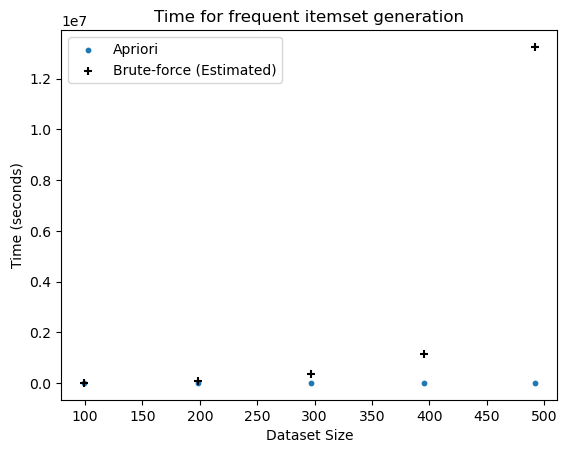

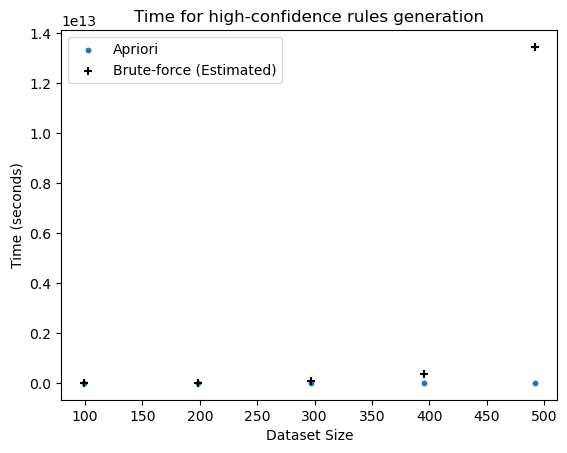

In [190]:
#plot time on large datasets

def to_plot_large_datatsets(times_1, times_3, dataset_len, title ):
  # plot the measured time and the estimated time
  plt.scatter(dataset_len, times_1, s=10, label="Apriori")
  plt.scatter(dataset_len, times_3, color='black', marker='+', label="Brute-force (Estimated)")
  plt.title(title)
  plt.xlabel("Dataset Size")
  plt.ylabel("Time (seconds)")
  plt.legend()
  plt.show()


to_plot_large_datatsets(apriori_times_frequent, bf_times_frequent_estimated, dataset_len, 'Time for frequent itemset generation')
to_plot_large_datatsets(apriori_times_rules, bf_times_rules_estimated, dataset_len, 'Time for high-confidence rules generation')
